# Supervised Modelling

In [31]:
!pip install tslearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.2/358.2 KB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 127.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 58.3 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.metrics import dtw
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import mode

In [42]:
dfs = []
dfs.append(pd.read_csv('../data/supervised-dropped/AB3 - Main 3L.csv'))
dfs.append(pd.read_csv('../data/supervised-dropped/BS1 - Main 1L.csv'))
dfs.append(pd.read_csv('../data/supervised-dropped/BS4 - Main 4R.csv'))
dfs.append(pd.read_csv('../data/supervised-dropped/Sub - Feeder F02.csv'))

In [43]:
for cur_df in dfs:
    print(cur_df.shape)
    print(cur_df['label'].value_counts())
    print(f"Null Values: {cur_df.isna().sum().sum()}\n")

(4315, 4)
Non-production    2278
Production        1399
Power-up           326
Power-down         312
Name: label, dtype: int64
Null Values: 0

(2873, 4)
Non-production    1305
Production        1177
Power-down         199
Power-up           192
Name: label, dtype: int64
Null Values: 0

(5015, 4)
Non-production    2142
Production        2042
Power-up           435
Power-down         396
Name: label, dtype: int64
Null Values: 0

(5859, 4)
Non-production    2814
Production        1984
Power-down         682
Power-up           379
Name: label, dtype: int64
Null Values: 0



In [44]:
dfs[0].head()

,time,Measure,kWh,label
0,2022-01-03 00:00:00,AB3 - Main 3L,36.75,Non-production
1,2022-01-03 01:00:00,AB3 - Main 3L,36.75,Non-production
2,2022-01-03 02:00:00,AB3 - Main 3L,35.75,Non-production
3,2022-01-03 03:00:00,AB3 - Main 3L,36.25,Non-production
4,2022-01-03 04:00:00,AB3 - Main 3L,38.25,Non-production


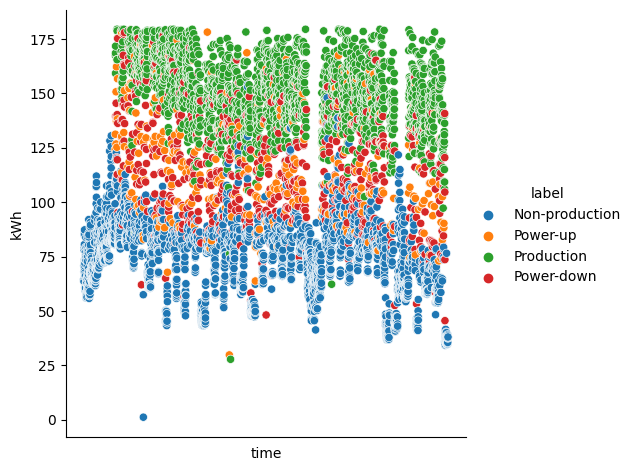

In [20]:
g = sns.relplot(x='time', y='kWh', data=dfs[3], kind='scatter', hue='label')
plt.xticks([])
plt.show()

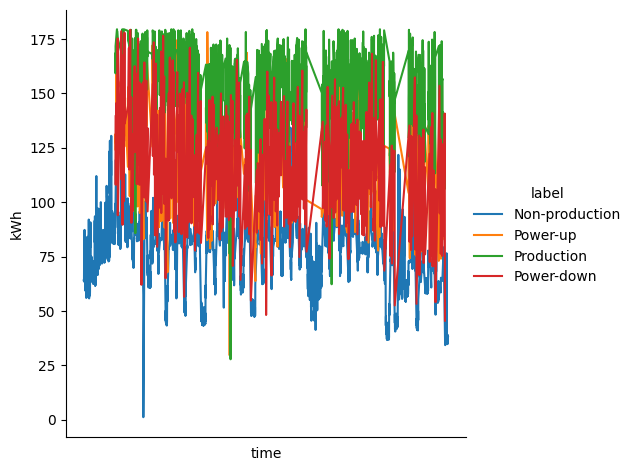

In [21]:
g = sns.relplot(x='time', y='kWh', data=dfs[3], kind='line', hue='label')
plt.xticks([])
plt.show()

In [19]:
DeepnoteChart(cur_df, """{"layer":[{"layer":[{"mark":{"clip":true,"type":"circle","tooltip":true},"encoding":{"x":{"sort":null,"type":"nominal","field":"time","scale":{"type":"linear","zero":false}},"y":{"sort":null,"type":"quantitative","field":"kWh","scale":{"type":"linear","zero":false},"format":{"type":"default","decimals":null},"aggregate":"sum","formatType":"numberFormatFromNumberType"},"color":{"sort":null,"type":"nominal","field":"label","scale":{"scheme":"tableau10"}}}}]}],"title":"","config":{"legend":{}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{}}""")

In [45]:
df_train = dfs[3].loc[0:5000]
df_test = dfs[3].loc[5000:]

In [46]:
df_train.head()

,time,Measure,kWh,label
0,2022-01-03 00:00:00,Sub - Feeder F02,64.25,Non-production
1,2022-01-03 01:00:00,Sub - Feeder F02,64.50,Non-production
2,2022-01-03 02:00:00,Sub - Feeder F02,63.50,Non-production
3,2022-01-03 03:00:00,Sub - Feeder F02,70.75,Non-production
4,2022-01-03 04:00:00,Sub - Feeder F02,68.00,Non-production


In [47]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   time     5001 non-null   object 
 1   Measure  5001 non-null   object 
 2   kWh      5001 non-null   float64
 3   label    5001 non-null   object 
dtypes: float64(1), object(3)
memory usage: 156.4+ KB


In [28]:
# Extract time series data from DataFrame
data = df_train.groupby('label')['kWh'].apply(list).values

# Encode labels as integers
le = LabelEncoder()
y = le.fit_transform(df_train['label'])

# Create matrix X with dynamic time warping distance
X = np.zeros((len(data), len(max(data, key=len))))
for i, row in enumerate(data):
    X[i, :len(row)] = row

# Exclude first and last columns
X = X[:, 1:-1]

### Set up X and y

In [ ]:
# Extract the time series data (kWh column)
X = df_train[['kWh']].values

# Scale the time series data
scaler = TimeSeriesScalerMeanVariance()
X_scaled = scaler.fit_transform(X)

# Extract the labels
y = df_train['label'].values

### Train Model

In [48]:

# Compute pairwise DTW distances between time series
distances = np.zeros((len(X_scaled), len(X_scaled)))
for i in range(len(X_scaled)):
    for j in range(i+1, len(X_scaled)):
        distances[i,j] = dtw(X_scaled[i], X_scaled[j])
        distances[j,i] = distances[i,j]

# Cluster the time series using k-means
n_clusters = 4   # number of clusters
km = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw")
km.fit(X)

Cluster labels: [0 0 0 ... 3 1 2] 5001
Accuracy: 0.0


### Evaluate Model

In [55]:
# Encode y to calculate accuracy score
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Print the accuracy score
accuracy = accuracy_score(y_encoded, km.labels_)
print("Accuracy:", accuracy)
print(f"Target:    {y_encoded}")
print(f"Predicted: {km.labels_}") # predicted

Accuracy: 0.5028994201159768
Target:    [0 0 0 ... 3 1 1]
Predicted: [0 0 0 ... 3 1 2]


In [51]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(y_encoded)
print(km.labels_)
accuracy = accuracy_score(y_encoded, km.labels_)
print("Accuracy:", accuracy)

[0 0 0 ... 3 1 1]
[0 0 0 ... 3 1 2]
Accuracy: 0.5028994201159768


In [65]:
from sklearn.preprocessing import LabelEncoder
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv("../data/supervised/AB3 - Main 3L.csv", parse_dates=["time"])
X = df[["time", "kWh"]].values
y = df["label"].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Scale the time series data
scaler = TimeSeriesScalerMeanVariance()
X_scaled = scaler.fit_transform(X[:, 1:])

# Split the scaled data based on labels
X_split = [X_scaled[y_encoded == i] for i in range(len(le.classes_))]

# Train k-means models on each split dataset
kmeans_models = []
for X in X_split:
    kmeans = TimeSeriesKMeans(n_clusters=4, metric="dtw")
    kmeans.fit(X)
    kmeans_models.append(kmeans)

# Predict clusters for new data
new_df = pd.read_csv("../data/supervised/BS1 - Main 1L.csv", parse_dates=["time"])
new_X = new_df[["time", "kWh"]].values
new_X_scaled = scaler.transform(new_X[:, 1:])
new_y_pred = []
for x in new_X_scaled:
    distances = [kmeans.transform([x]) for kmeans in kmeans_models]
    closest_cluster = np.argmin(distances)
    new_y_pred.append(closest_cluster)

# Inverse transform predicted labels
new_y_pred = le.inverse_transform(new_y_pred)


In [67]:
accuracy_score(new_df['label'], new_y_pred)

0.2876984126984127

In [58]:
# Initialize a list to hold the scaled datasets
X_scaled = []

# Scale and transform each dataset using TimeSeriesScalerMeanVariance
for X in [X1, X2, X3]:
    scaler = TimeSeriesScalerMeanVariance()
    X_scaled.append(scaler.fit_transform(X))

# Concatenate the scaled datasets along the time axis
X_concatenated = np.concatenate(X_scaled, axis=0)

# Fit a standard scaler to the concatenated dataset
standard_scaler = StandardScaler()
standard_scaler.fit(X_concatenated)

# Scale and transform each dataset using the standard scaler
X_scaled = []

for X in X_scaled:
    X_scaled.append(standard_scaler.transform(X))

# Initialize the TimeSeriesKMeans model and fit it to the scaled datasets
n_clusters = 4   # number of clusters
km = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw")

for X in X_scaled:
    km.fit(X)

# Predict cluster labels for new dataset
X_new_scaled = scaler.transform(X_new)
X_new_scaled = standard_scaler.transform(X_new_scaled)
labels = km.predict(X_new_scaled)

ValueError: could not convert string to float: '2022-01-03 00:00:00'

In [ ]:
print(df['label'].value_counts())
print(df2['label'].value_counts())

Non-production    2278
Production        1371
unclassified       670
Power-down         545
Power-up           542
Name: label, dtype: int64
Non-production    2278
Production        1378
Power-down         545
Power-up           542
Name: label, dtype: int64


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4743 entries, 0 to 4742
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   time     4743 non-null   object 
 1   Measure  4743 non-null   object 
 2   kWh      4743 non-null   float64
 3   label    4743 non-null   object 
dtypes: float64(1), object(3)
memory usage: 148.3+ KB


In [ ]:
df2.head()

,time,Measure,kWh,label
0,2022-01-03 00:00:00,AB3 - Main 3L,36.75,Non-production
1,2022-01-03 01:00:00,AB3 - Main 3L,36.75,Non-production
2,2022-01-03 02:00:00,AB3 - Main 3L,35.75,Non-production
3,2022-01-03 03:00:00,AB3 - Main 3L,36.25,Non-production
4,2022-01-03 04:00:00,AB3 - Main 3L,38.25,Non-production


# Modelling

In [76]:
# imports
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [90]:
# Load the dataframe
df = pd.read_csv('../data/supervised-dropped/AB3 - Main 3L.csv')

# Preprocess the data
df['time'] = pd.to_datetime(df['time'])
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['day'] = df['time'].dt.day
df['hour'] = df['time'].dt.hour
df['weekday'] = df['time'].dt.weekday
df = df.drop('time', axis=1)
df['Measure'] = LabelEncoder().fit_transform(df['Measure'])
scaler = StandardScaler()
df['kWh'] = scaler.fit_transform(df[['kWh']])
df['label'] = LabelEncoder().fit_transform(df['label'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('label', axis=1), df['label'], test_size=0.2, random_state=42)

# Train a Random Forest model on the training data
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the performance of the model on the testing data
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Make predictions on new data
new_data = pd.DataFrame({'time': ['2022-01-01 00:00:00', '2022-01-01 01:00:00'], 'Measure': ['A', 'B'], 'kWh': [10.0, 20.0]})
new_data['time'] = pd.to_datetime(new_data['time'])
new_data['year'] = new_data['time'].dt.year
new_data['month'] = new_data['time'].dt.month
new_data['day'] = new_data['time'].dt.day
new_data['hour'] = new_data['time'].dt.hour
new_data['weekday'] = new_data['time'].dt.weekday
new_data = new_data.drop('time', axis=1)
new_data['Measure'] = LabelEncoder().fit_transform(new_data['Measure'])
new_data['kWh'] = scaler.transform(new_data[['kWh']])
new_pred = model.predict(new_data)
print("Predictions:", new_pred)

Accuracy: 0.947856315179606
Predictions: [0 0]


# Evaluation

In [91]:
# Load the new data
test_data = pd.read_csv('../data/supervised-dropped/BS1 - Main 1L.csv')


In [92]:
# Preprocess the new data
# Preprocess the data
test_data['time'] = pd.to_datetime(test_data['time'])
test_data['year'] = test_data['time'].dt.year
test_data['month'] = test_data['time'].dt.month
test_data['day'] = test_data['time'].dt.day
test_data['hour'] = test_data['time'].dt.hour
test_data['weekday'] = test_data['time'].dt.weekday
test_data = test_data.drop('time', axis=1)
test_data['Measure'] = LabelEncoder().fit_transform(test_data['Measure'])
scaler = StandardScaler()
test_data['kWh'] = scaler.fit_transform(test_data[['kWh']])
test_data['label'] = LabelEncoder().fit_transform(test_data['label'])

In [93]:
# Make predictions on the new data
new_pred = model.predict(test_data.drop("label", axis=1))
new_pred

array([0, 0, 0, ..., 0, 0, 0])

In [94]:
# Load the correct labels for the new data
new_labels = pd.read_csv('../data/supervised-dropped/BS1 - Main 1L.csv')["label"]

# encode y
le = LabelEncoder()
y_encoded = le.fit_transform(new_labels)

# Calculate the accuracy of the model on the new data
new_accuracy = accuracy_score(y_encoded, new_pred)
print("Accuracy on new data:", new_accuracy)
print(y_encoded)
print(new_pred)

Accuracy on new data: 0.9300382875043508
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


In [84]:
print(y_encoded)
print(km.labels_)
accuracy = accuracy_score(y_encoded, km.labels_)
print("Accuracy:", accuracy)

0       Non-production
1       Non-production
2       Non-production
3       Non-production
4       Non-production
             ...      
2868    Non-production
2869    Non-production
2870    Non-production
2871    Non-production
2872    Non-production
Name: label, Length: 2873, dtype: object
0       0
1       0
2       0
3       0
4       0
       ..
2868    0
2869    0
2870    0
2871    0
2872    0
Name: label, Length: 2873, dtype: int64


In [101]:
def eval_model(fileName):
    # Preprocess
    test_data = pd.read_csv('../data/supervised-dropped/' + fileName)
    test_data['time'] = pd.to_datetime(test_data['time'])
    test_data['year'] = test_data['time'].dt.year
    test_data['month'] = test_data['time'].dt.month
    test_data['day'] = test_data['time'].dt.day
    test_data['hour'] = test_data['time'].dt.hour
    test_data['weekday'] = test_data['time'].dt.weekday
    test_data = test_data.drop('time', axis=1)
    test_data['Measure'] = LabelEncoder().fit_transform(test_data['Measure'])
    scaler = StandardScaler()
    test_data['kWh'] = scaler.fit_transform(test_data[['kWh']])
    test_data['label'] = LabelEncoder().fit_transform(test_data['label'])

    # Predict
    new_pred = model.predict(test_data.drop("label", axis=1))
    new_pred

    # Load the correct labels for the new data
    y = pd.read_csv('../data/supervised-dropped/' + fileName)['label']

    # encode y
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Calculate the accuracy of the model on the new data
    new_accuracy = accuracy_score(y_encoded, new_pred)
    print("Accuracy on new data:", new_accuracy)
    print(y_encoded)
    print(new_pred)

In [105]:
eval_model('AB3 - Main 3L.csv')
eval_model('BS1 - Main 1L.csv')
eval_model('BS4 - Main 4R.csv')
eval_model('Sub - Feeder F02.csv')

Accuracy on new data: 0.9895712630359212
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
Accuracy on new data: 0.9300382875043508
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
Accuracy on new data: 0.8969092721834496
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
Accuracy on new data: 0.868236900494965
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


In [106]:
# Final Evaluation:
# Preprocess
test_data = pd.read_csv('../data/holdout.csv')
test_data['time'] = pd.to_datetime(test_data['time'])
test_data['year'] = test_data['time'].dt.year
test_data['month'] = test_data['time'].dt.month
test_data['day'] = test_data['time'].dt.day
test_data['hour'] = test_data['time'].dt.hour
test_data['weekday'] = test_data['time'].dt.weekday
test_data = test_data.drop('time', axis=1)
test_data['Measure'] = LabelEncoder().fit_transform(test_data['Measure'])
scaler = StandardScaler()
test_data['kWh'] = scaler.fit_transform(test_data[['kWh']])
test_data['label'] = LabelEncoder().fit_transform(test_data['label'])

# Predict
new_pred = model.predict(test_data.drop("label", axis=1))
new_pred

# Load the correct labels for the new data
y = pd.read_csv('../data/holdout.csv')['label']

# encode y
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Calculate the accuracy of the model on the new data
new_accuracy = accuracy_score(y_encoded, new_pred)
print("Accuracy on new data:", new_accuracy)
print(y_encoded)
print(new_pred)

Accuracy on new data: 0.7394216133942161
[0 0 0 ... 1 1 1]
[2 2 2 ... 0 0 1]


# Ensemble Model

In [115]:
# Load the dataframes
df1 = pd.read_csv('../data/supervised-dropped/AB3 - Main 3L.csv')
df2 = pd.read_csv('../data/supervised-dropped/BS1 - Main 1L.csv')
df3 = pd.read_csv('../data/supervised-dropped/BS4 - Main 4R.csv')

In [ ]:
# Concatenate the dataframes vertically
df = pd.concat([df1, df2, df3])

# Preprocess the data
df['time'] = pd.to_datetime(df['time'])
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['day'] = df['time'].dt.day
df['hour'] = df['time'].dt.hour
df['weekday'] = df['time'].dt.weekday
df = df.drop('time', axis=1)
df['Measure'] = LabelEncoder().fit_transform(df['Measure'])
scaler = StandardScaler()
df['kWh'] = scaler.fit_transform(df[['kWh']])
df['label'] = LabelEncoder().fit_transform(df['label'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('label', axis=1), df['label'], test_size=0.2, random_state=42)

# Train multiple Random Forest models on the training data
models = []
for i in range(3):
    model = RandomForestClassifier(n_estimators=100, random_state=42+i)
    model.fit(X_train, y_train)
    models.append(model)

# Ensemble the models and evaluate the performance on the testing data
y_preds = []
for model in models:
    y_pred = model.predict(X_test)
    y_preds.append(y_pred)

y_preds = np.array(y_preds)
y_pred_ensemble = mode(y_preds)[0][0]
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
print("Accuracy of ensemble model:", accuracy_ensemble)


In [108]:
# Concatenate the dataframes vertically
df = pd.concat([df1, df2, df3])

# Preprocess the data
df['time'] = pd.to_datetime(df['time'])
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['day'] = df['time'].dt.day
df['hour'] = df['time'].dt.hour
df['weekday'] = df['time'].dt.weekday
df = df.drop('time', axis=1)
df['Measure'] = LabelEncoder().fit_transform(df['Measure'])

# Scale the data
scaler = StandardScaler()
df[['kWh']] = scaler.fit_transform(df[['kWh']])
df[['V1', 'V2', 'V3']] = scaler.transform(df[['V1', 'V2', 'V3']])

# Encode the labels
df['label'] = LabelEncoder().fit_transform(df['label'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('label', axis=1), df['label'], test_size=0.2, random_state=42)

# Train multiple Random Forest models on the training data
models = []
for i in range(3):
    model = RandomForestClassifier(n_estimators=100, random_state=42+i)
    model.fit(X_train, y_train)
    models.append(model)

# Ensemble the models and evaluate the performance on the testing data
y_preds = []
for model in models:
    y_pred = model.predict(X_test)
    y_preds.append(y_pred)

y_preds = np.array(y_preds)
y_pred_ensemble = mode(y_preds)[0][0]
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
print("Accuracy of ensemble model:", accuracy_ensemble)


KeyError: "None of [Index(['V1', 'V2', 'V3'], dtype='object')] are in the [columns]"

In [116]:
df1.head()

,time,Measure,kWh,label
0,2022-01-03 00:00:00,AB3 - Main 3L,36.75,Non-production
1,2022-01-03 01:00:00,AB3 - Main 3L,36.75,Non-production
2,2022-01-03 02:00:00,AB3 - Main 3L,35.75,Non-production
3,2022-01-03 03:00:00,AB3 - Main 3L,36.25,Non-production
4,2022-01-03 04:00:00,AB3 - Main 3L,38.25,Non-production


In [117]:
# Drop the irrelevant columns
df1 = df1.drop(['time', 'Measure'], axis=1)
df2 = df2.drop(['time', 'Measure'], axis=1)
df3 = df3.drop(['time', 'Measure'], axis=1)

# Concatenate the dataframes vertically
df = pd.concat([df1, df2, df3])

# Encode the labels
df['label'] = LabelEncoder().fit_transform(df['label'])

# Scale the data
scaler = StandardScaler()
df[['kWh']] = scaler.fit_transform(df[['kWh']])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('label', axis=1), df['label'], test_size=0.2, random_state=42)

# Train multiple Random Forest models on the training data
models = []
for i in range(3):
    model = RandomForestClassifier(n_estimators=100, random_state=42+i)
    model.fit(X_train, y_train)
    models.append(model)

# Ensemble the models and evaluate the performance on the testing data
y_preds = []
for model in models:
    y_pred = model.predict(X_test)
    y_preds.append(y_pred)

y_preds = np.array(y_preds)
y_pred_ensemble = mode(y_preds)[0][0]
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
print("Accuracy of ensemble model:", accuracy_ensemble)


Accuracy of ensemble model: 0.8562064727570667
/tmp/ipykernel_87/923637454.py:33: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  y_pred_ensemble = mode(y_preds)[0][0]


In [109]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4315 entries, 0 to 4314
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   time     4315 non-null   object 
 1   Measure  4315 non-null   object 
 2   kWh      4315 non-null   float64
 3   label    4315 non-null   object 
dtypes: float64(1), object(3)
memory usage: 135.0+ KB


In [124]:
# Load the new dataframe
new_df = pd.read_csv('../data/holdout.csv')

# Preprocess the data
new_df['time'] = pd.to_datetime(new_df['time'])
new_df['year'] = new_df['time'].dt.year
new_df['month'] = new_df['time'].dt.month
new_df['day'] = new_df['time'].dt.day
new_df['hour'] = new_df['time'].dt.hour
new_df['weekday'] = new_df['time'].dt.weekday
new_df = new_df.drop('time', axis=1)
new_df['Measure'] = LabelEncoder().fit_transform(new_df['Measure'])
new_df['kWh'] = scaler.transform(new_df[['kWh']])
new_df['label'] = LabelEncoder().fit_transform(new_df['label'])

# Make predictions on the new dataframe
y_pred_new = model.predict(new_df.drop('label', axis=1))

# Evaluate the performance of the model on the new dataframe
accuracy_new = accuracy_score(new_df['label'], y_pred_new)
print("Accuracy on new data:", accuracy_new)


Accuracy on new data: 0.5485540334855403


## Random Stuff

In [ ]:
import numpy as np
from dtw import distance

# create training data
train_data = []
train_labels = []
for i in range(23):
    # load data from each dataframe
    # assuming each dataframe has columns 'time', 'location', 'kWh', and 'label'
    data = pd.read_csv(f"dataframe_{i}.csv")
    # extract features
    features = data[['time', 'kWh']].values
    # compute DTW distance matrix
    dist_mat = np.zeros((len(features), len(features)))
    for i in range(len(features)):
        for j in range(i, len(features)):
            dist_mat[i,j] = distance(features[i], features[j])
            dist_mat[j,i] = dist_mat[i,j]
    # add to training data
    train_data.append(dist_mat)
    train_labels.append(data['label'].values)

# create test data
# assuming new_data is a dataframe with columns 'time', 'location', 'kWh'
test_features = new_data[['time', 'kWh']].values
test_dist_mat = np.zeros((len(test_features), len(test_features)))
for i in range(len(test_features)):
    for j in range(i, len(test_features)):
        test_dist_mat[i,j] = distance(test_features[i], test_features[j])
        test_dist_mat[j,i] = test_dist_mat[i,j]

# train model
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5, metric='precomputed')
knn.fit(train_data, train_labels)

# make predictions on test data
test_pred = knn.predict(test_dist_mat)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fcd88216-8b90-498f-93c2-40c9e3976e41' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>